# Q&A Hannover Re's quarterly result

In this workbook, we construct a simple agent to answer question regarding Hannover Re's quarterly result. We will define 2 llms inside a LangGraph. The first one is gemini-2.5-flash which is going to extract the answer, and gemini-2.0-flash is the 2nd one to bring the answers in a structured format.

In [ ]:
%%capture
%pip install langchain-community langchain_google_genai langgraph

In [2]:
import os
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI

api_key = os.environ.get("GOOGLE_API_KEY")
genai.configure(api_key=api_key)

os.environ["GOOGLE_API_KEY"] = api_key
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0)
llm_to_summarize = ChatGoogleGenerativeAI(model = "gemini-2.0-flash", temperature = 0.2)

## Load the 2025Q1 quarterly results presentation 

The presentation available online via https://assets.hannover-re.com/asset/533267266226/document_ccm2p880911ul0kum1pracq67k/ConCall_May2025.pdf?content-disposition=inline

In [3]:
from langchain.document_loaders import PyPDFLoader

pdf_path = "ConCall_May2025.pdf" 
loader = PyPDFLoader(pdf_path) # PyPDF load the documents pagewise
documents = loader.load()

In [4]:
print(documents[4].page_content)

Increase in CSM and RA based on successful new business generation
Shareholders' equity increased by 2.4%
Conference Call on Q1/2025 financial results
Change in shareholders' equity Contractual Service Margin (CSM) and Risk Adjustment (RA)
Figures in EUR m. unless otherwise stated 
|  1  Group overview |  2  |  3  |  4  |  5  |  6  |
5
11,794 480 
-96 
317 
-414 
12,082 
Shareholders'
equity
31.12.2024
Group Net
income
Change in
OCI
Reinsurance
Liabilities
Change in
OCI
Investments
Currency
translation
and other
Shareholders'
equity
31.03.2025
1,646 2,401
6,517
6,448
987
1,083
3,017
3,052
12,166
12,984
31/12/2024 31/03/2025
CSM P&C
RA P&C
RA L&H
CSM L&H
CSM
+8.4%
Total
+6.7%
RA
+3.3%


## Construct the Graph

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = ChatPromptTemplate.from_messages([ # Chat template for the first llm
    ("system", 
"""You are a financial expert answering question about Hannover Re's financial statement.
The documents about the current quarterly results are {quarterly_result}.
You always answer precise and short. If you don't know the answer, just say I don't know. Don't try to make up an answer."""
    ),
    ("placeholder", "{messages}"
    )
])

analyst_llm = template | llm

In [6]:
(analyst_llm | StrOutputParser()).invoke({"messages" : [("user", "How many pages does the provided documents have?")], "quarterly_result" : documents})

'The provided document has 29 pages.'

In [7]:
from pydantic import BaseModel, Field
from typing import TypedDict, List, Annotated

class Results(BaseModel): # class for the summarizer llm_for_summarizing
    list_answers : List[str] = Field("List of answers to every question.")

    
class Graph(TypedDict): # define the graph
    input : List[str]
    answers : List[str]
    final : Results

This will define the first node for question answering.

In [8]:
def question_answering(state: Graph) -> Graph:
    answers = []
    for i in state["input"]:
        output = analyst_llm.invoke({"messages" : [("user", i)], "quarterly_result" : documents}) # fix the quarterly result document. Can be made variable easily
        answers.append(output.content)
    return {"answers" : answers}

In [9]:
template_summarize = ChatPromptTemplate.from_template( # chat template for llm_for_summarizing
"""
You are provided with questions and answers. Your task is to summarize the answers in a structured format.
Do not add any additional information or answers. 

{q_and_a}

**Important**:
- The output must contain exactly {num_items} items.
- Only retain the very main information. If numbers answer the question, do not output anything else.
"""
)

summarizer = template_summarize | llm_to_summarize.with_structured_output(Results)

2nd node for summarizing the results

In [10]:
def summarize_response(state: Graph) -> Graph:
    q_and_a = [
    f"Q{i+1}: {q}\nA{i+1}: {a}" for i, (q, a) in enumerate(zip(state["input"], state["answers"]))
    ]
    q_and_a = "\n\n".join(q_and_a)
    return {"final" : summarizer.invoke({"q_and_a" : q_and_a, "num_items" : len(state["input"])})}

In [11]:
from langgraph.graph import StateGraph, START

builder = StateGraph(Graph)

builder.add_node("answer", question_answering)
builder.add_node("summarize", summarize_response)

builder.add_edge(START, "answer")
builder.add_edge("answer","summarize")


graph = builder.compile()

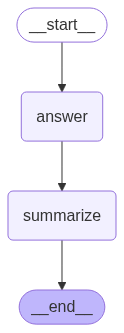

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Define a couple different question: questions is about the Hannover Re group, questions_lh is about the life and health business aund questions_pc the property and casualty business. The hardest questions are likely questions[1], which is a word inside a graphic, and questions_pc[1], where the model has to do multiple steps in a row: first find the 2022 reservce, then the 2024 reserves and finally subtract them.

sols provides the solutions for testing.

In [18]:
questions = ["The increase in CSM and risk adjustment in Q1/2025 (in %, compared to year-end 2024).",
            "Which asset class contributed the most to ordinary (investment) income in Q1/2025.",
            "The currency result in Q1/2025 (in EUR million)."]

questions_lh = ["The main drivers for the decrease in reinsurance revenue in Q1/2025.",
                "The main drivers for the new business generation in Q1/2025."]

questions_pc = ["The net impact from large lossesn Q1/2025 as percentage of the net large-loss budget for the full year 2025 (in %).",
               "The increase in resilience reserves since year-end 2022 (in EUR million, until year-end 2024)."]

sols = ["CSM +8.4%, RA +3.3%", "Corporates", "66m", "36%", "1,145m", "mainly driven by US mortality", "diversified contribution from Financial solutions, Morbidity and mortality"]

In [19]:
list_of_questions = (["These questions are general questions about the document: " + question for question in questions] 
+ ["These questions are about Life and Health business: " + question for question in questions_lh]
+ ["These questions are about Property and Casualty business:  " + question for question in questions_pc] 
)

In [20]:
graph.invoke({"input" : list_of_questions})["final"].list_answers

['CSM increased by 8.4%, RA increased by 3.3%.',
 'Corporates (33%)',
 'EUR 66 million',
 'US mortality',
 'Financial Solutions, Morbidity, and Mortality business',
 '36.4%',
 'EUR 1,145 million']

The answers are all correct!

A follow up on this would be to provide the llm with tools like duck duck go or tavily so it find the analyst presentation itself, instead of directly providing it.